In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import utils.data as data
from utils.visualisation import visualise_image
import config
from torch.utils.data import DataLoader



device = config.device
DATA_PATH = config.PATH_TO_DATA
print(DATA_PATH)



dataset


In [32]:
dataset = data.PlanetDataset(bands=[0,1,2,3])
print(dataset)

dataloader = DataLoader(dataset, batch_size=4, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0)

dataloader = iter(dataloader)

PlanetDataset(root=dataset, num_samples=1612, transform=None, target_transform=None)


### 1. Example : loading data samples from dataset

<class 'torch.Tensor'>
Batch sample shape (batch, x, y, n_channels): torch.Size([4, 128, 128, 4])
Batch mask shape (batch, x, y): torch.Size([4, 128, 128])


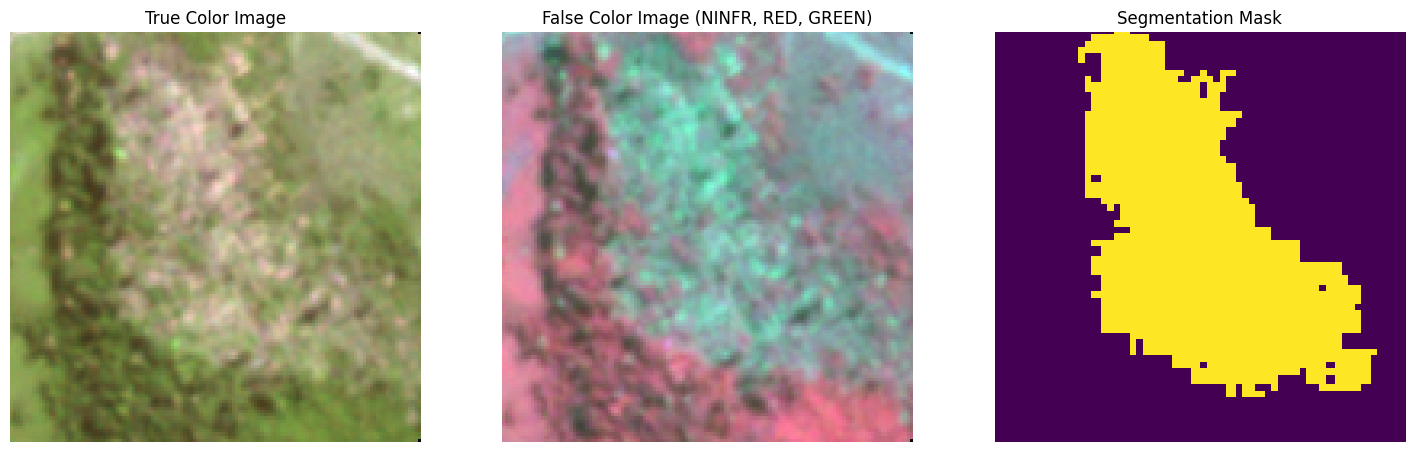

In [33]:
sample, mask = next(dataloader)
print(type(sample))
print(f"Batch sample shape (batch, x, y, n_channels): {sample.shape}")
print(f"Batch mask shape (batch, x, y): {mask.shape}")
visualise_image(sample[0].squeeze().numpy(),mask[0].squeeze().numpy())

### 2. Choosing framework to implement transforms/data augmentation functions

In [34]:
### Option 1 : torchgeo + Kornia
import torch

### ATTENTION : this framework requires that sample tensors are of shape (batch, n_channels, x, y)
# Doc: https://torchgeo.readthedocs.io/en/latest/tutorials/transforms.html
# https://torchgeo.readthedocs.io/en/latest/api/transforms.html
# 
sample = torch.permute(sample,(0,3,1,2))


In [35]:
sample.shape


torch.Size([4, 4, 128, 128])

Note that we have a new channel corresponding to NDVI: torch.Size([4, 128, 128, 5])


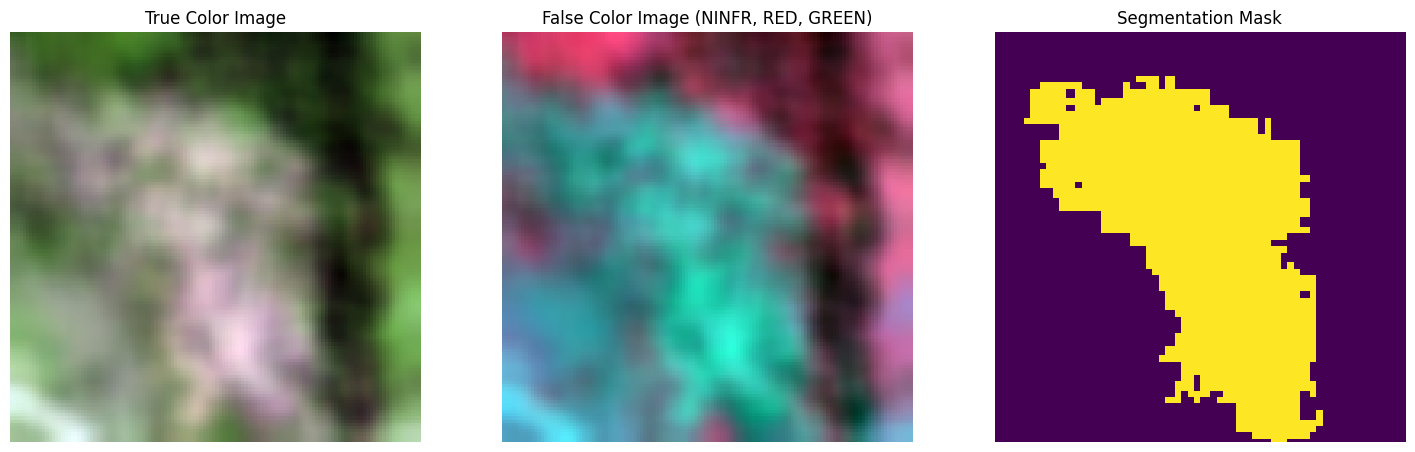

In [45]:

from torchvision.transforms import v2
import kornia.augmentation as K
from torchgeo.transforms import AugmentationSequential, indices
transforms = AugmentationSequential(
    indices.AppendNDVI(index_nir=3, index_red=0), #There are very handy torchgeo functions for calculating indices!
    K.RandomHorizontalFlip(p=1),
    K.RandomVerticalFlip(p=1),
    K.RandomBoxBlur(kernel_size=(10, 10), border_type='reflect', normalized=True, p=1), #Note that the randomblur is applied to the image but no the mask!
    data_keys=["image","mask"],
)
transformed_tuple = transforms({"image" : sample, "mask" : mask})

# Unshuffle dimensions of sample so it is compatible with Luca's visualize_image:

transformed_tuple['image'] = torch.permute(transformed_tuple['image'],(0,2,3,1))

visualise_image(transformed_tuple['image'][0].squeeze().numpy(),transformed_tuple['mask'][0].squeeze().numpy())

print(f"Note that we have a new channel corresponding to NDVI: {transformed_tuple['image'].shape}")


In [ ]:
### Option 2 : torch transforms v2 (implemented in beta since March 2023)
